In [1]:
# Mengatur jumlah thread CPU yang akan digunakan
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '12'  # Mengatur maksimal 12 core CPU

In [2]:
from sklearn.datasets import load_iris
import pandas as pd

# Memuat dataset iris
iris = load_iris()

# Mengkonversi dataset iris ke DataFrame pandas
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Menambahkan kolom target
df['species'] = iris.target

In [3]:
# EDA
print(f'features name : \n{iris.feature_names}\n')
print(f'target name : \n{iris.target_names}')
print(f'5 data teratas: {df.head()}\n')
print(f'Cek missing values: {df.isnull().sum()}')

features name : 
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

target name : 
['setosa' 'versicolor' 'virginica']
5 data teratas:    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  

Cek missing values: sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64


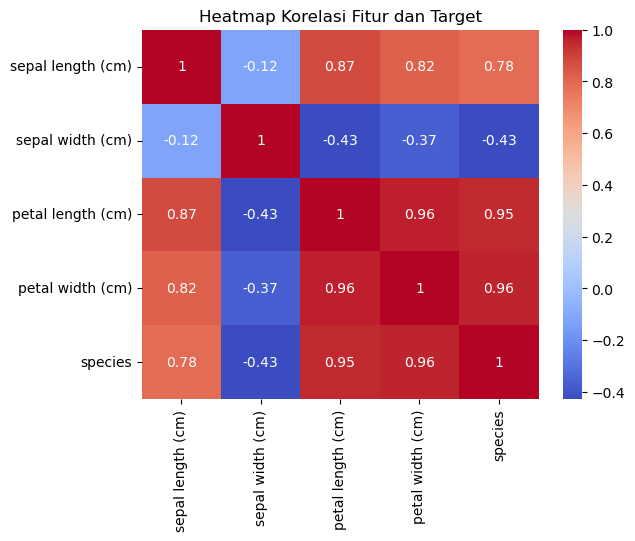

In [4]:
# cek distribusi data
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur dan Target")
plt.show()

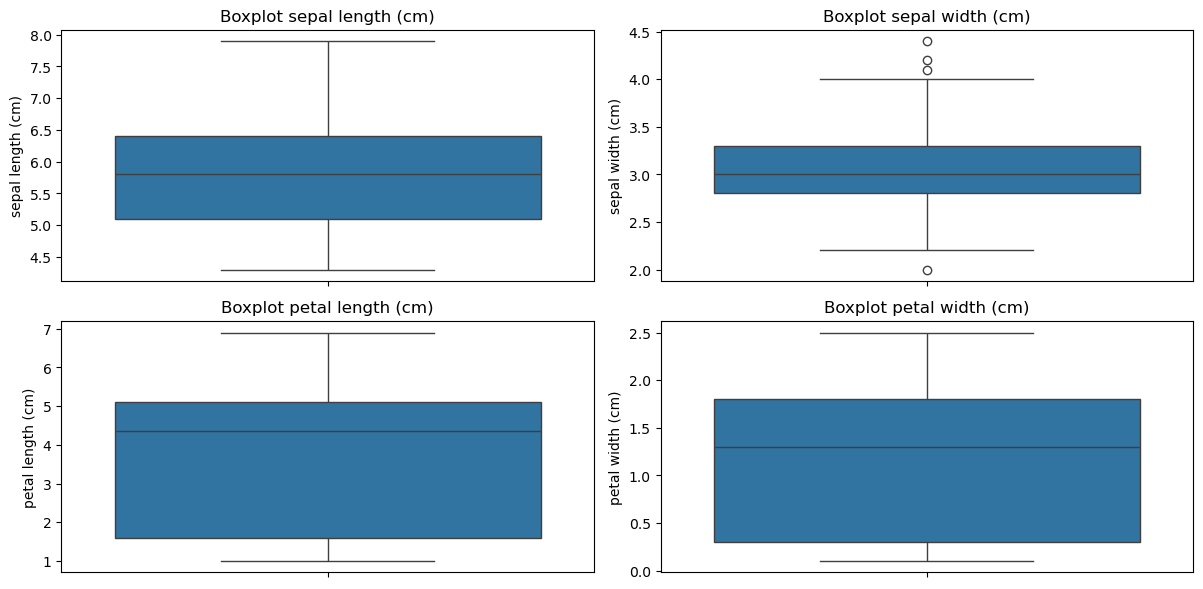


Deteksi Outlier Menggunakan IQR:

Outlier pada sepal length (cm):
Batas bawah: 3.15, Batas atas: 8.35
Jumlah outlier: 0

Outlier pada sepal width (cm):
Batas bawah: 2.05, Batas atas: 4.05
Jumlah outlier: 4
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
15                5.7               4.4                1.5               0.4   
32                5.2               4.1                1.5               0.1   
33                5.5               4.2                1.4               0.2   
60                5.0               2.0                3.5               1.0   

    species  
15        0  
32        0  
33        0  
60        1  

Outlier pada petal length (cm):
Batas bawah: -3.65, Batas atas: 10.35
Jumlah outlier: 0

Outlier pada petal width (cm):
Batas bawah: -1.95, Batas atas: 4.05
Jumlah outlier: 0


In [5]:
# Cek Outlier
# Mengecek outlier menggunakan boxplot
plt.figure(figsize=(12, 6))
for i, feature in enumerate(iris.feature_names):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot {feature}')
plt.tight_layout()
plt.show()

# Mengecek outlier menggunakan IQR (Interquartile Range)
print("\nDeteksi Outlier Menggunakan IQR:")
for feature in iris.feature_names:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\nOutlier pada {feature}:")
    print(f"Batas bawah: {lower_bound:.2f}, Batas atas: {upper_bound:.2f}")
    print(f"Jumlah outlier: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers)


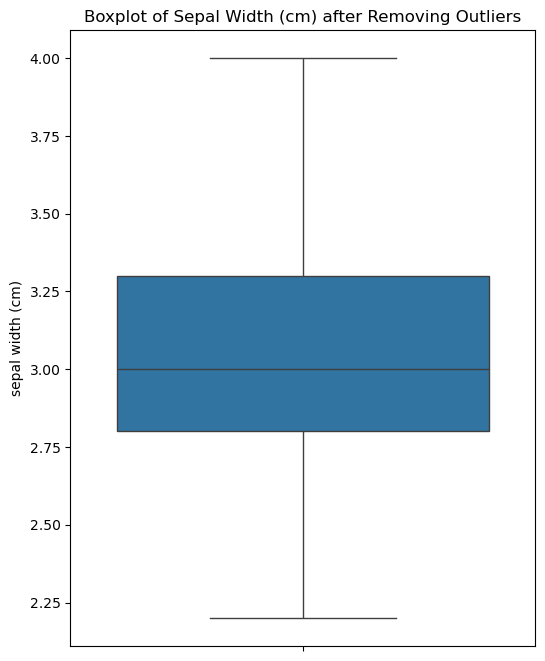

In [6]:
# handle outlier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi buat handle outlier pake metode IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Batas bawah dan atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data yang di dalam range
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean

# Handle outlier di 'sepal width (cm)'
df_outliers_removed = remove_outliers(df, 'sepal width (cm)')

# Plot boxplot setelah outlier dihapus
plt.figure(figsize=(6, 8))
sns.boxplot(y=df_outliers_removed['sepal width (cm)'])
plt.title('Boxplot of Sepal Width (cm) after Removing Outliers')
plt.show()


In [7]:
# split data
from sklearn.model_selection import train_test_split

X = df_outliers_removed.drop(columns=['species'])
y = df_outliers_removed['species']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [8]:
# Training Model
from sklearn.neighbors import KNeighborsRegressor

# Model
knn = KNeighborsRegressor(n_neighbors=5)

# fitting model
knn.fit(X_train, y_train)

# prediksi model
y_pred = knn.predict(X_test)

# evaluasi model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
print(f'mse : {mse}')

r2 = r2_score(y_test, y_pred)
print(f'r2 : {r2}')

mse : 0.02133333333333333
r2 : 0.968


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint
# RandomsearchCV
# Define the parameter grid
param_distributions = {
    'n_neighbors': randint(1, 30),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create KNN regressor
knn = KNeighborsRegressor()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,        # Number of cross-validation folds
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1    # Use all available processors
)

# Fit the random search
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)  # Convert negative MSE back to positive

# gunakan model terbaik
best_model = random_search.best_estimator_

# prediksi model
y_pred_best = best_model.predict(X_test)

# evaluate model
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_best)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test,y_pred_best)
print('r2_score ', r2)


Best parameters: {'algorithm': 'brute', 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
Best score: 0.025598667032134807
Mean Squared Error: 0.02076372454094054
r2_score  0.9688544131885892


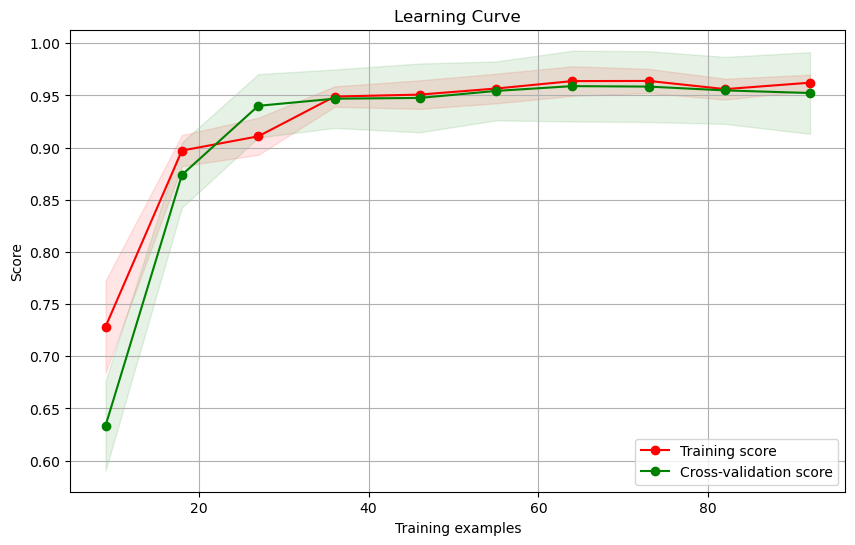

In [11]:
# learning curve berdasarkan RandomsearchCV

from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

## Kenapa Perlu Cek Distribusi Error (Residual)?
#### Dalam regresi, residual adalah selisih antara nilai asli (y_test) dan prediksi model (y_pred). Kalau modelnya bagus, error ini seharusnya acak dan terdistribusi normal (nggak ada pola tertentu).


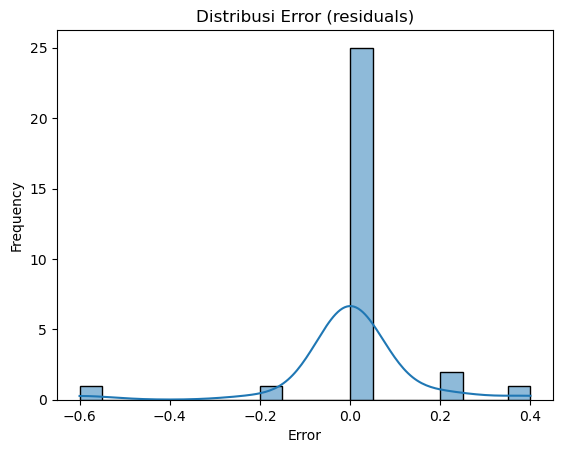

In [12]:
# 1. Histogram Error (Residual Distribution Plot)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_test - y_pred, bins=20, kde=True)
plt.title('Distribusi Error (residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#Cara baca hasilnya:
#Kalau bentuknya mendekati distribusi normal (seperti lonceng) → error tersebar secara acak → modelnya bagus.
#Kalau distribusinya miring ke kiri/kanan atau ada dua puncak → ada pola tertentu di error, modelnya bisa ditingkatkan.

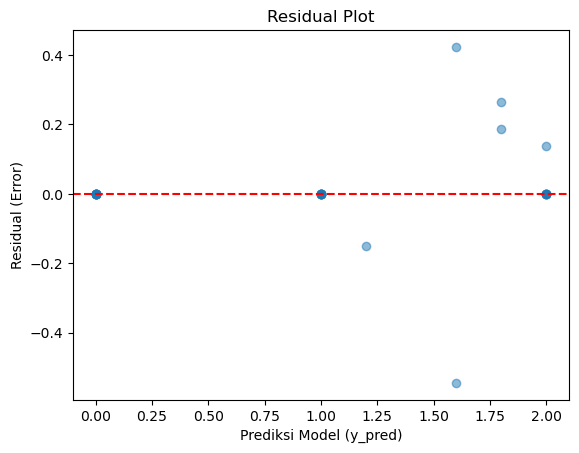

In [17]:
# 2. Residual Plot (Scatter Plot Residual)
import numpy as np

# hitung residual (selisih antara nilai asli dan prediksi)
residuals = y_test - y_pred_best

# plot residual
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Garis nol
plt.xlabel("Prediksi Model (y_pred)")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot")
plt.show()


#Cara baca hasilnya:
#Kalau titik-titik tersebar acak di sekitar garis y = 0, berarti errornya random → model bagus.
#Kalau ada pola tertentu (misalnya bentuk lengkung atau tren naik/turun) → model belum optimal.

In [18]:
# 3. Shapiro-Wilk Test (Uji Normalitas Residual)
from scipy.stats import shapiro

stat, p = shapiro(y_test - y_pred_best)
print(f'Statistik Uji: {stat}, p-value: {p}')

if p > 0.05:
    print("Residual terdistribusi normal")
else:
    print("Residual tidak terdistribusi normal")

#Cara baca hasilnya:
#Kalau p-value > 0.05 → residual normal → model cukup bagus.
#Kalau p-value ≤ 0.05 → residual tidak normal → ada kemungkinan model bisa lebih diperbaiki.


Statistik Uji: 0.5903997568989117, p-value: 5.583951827460434e-08
Residual tidak terdistribusi normal


#### Jadi intinya:
#### Histogram error buat lihat apakah distribusi error mendekati normal.
#### Residual plot buat lihat ada pola tertentu atau tidak dalam error.
#### Shapiro-Wilk test buat konfirmasi secara statistik apakah residualnya normal.

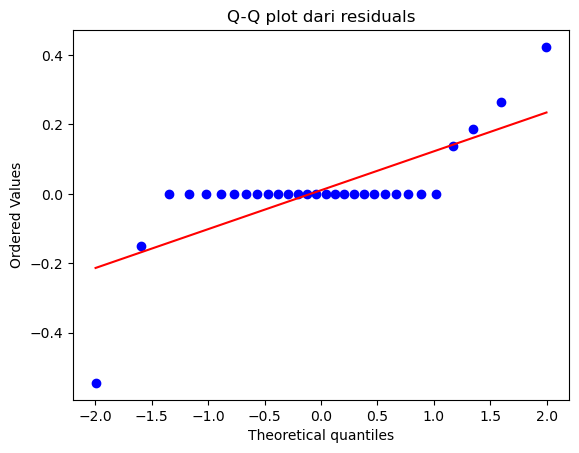

In [19]:
# Q-Q plot

#Q-Q plot ini buat ngecek apakah error (residual) dari model kamu tersebar secara normal atau enggak.
#Kalau titik-titik biru banyak yang ngepas di garis merah, berarti error-nya normal → bagus, modelnya bisa dipercaya.
#Kalau banyak titik jauh dari garis, berarti ada masalah, bisa jadi ada outlier atau pola tertentu di error-nya.
    
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(y_test - y_pred_best, dist="norm", plot=plt)
plt.title('Q-Q plot dari residuals')
plt.show()

In [ ]:
# 1. Histogram Error (Residual Distribution Plot)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_test - y_pred, bins=20, kde=True)
plt.title('Distribusi Error (residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

#Cara baca hasilnya:
#Kalau bentuknya mendekati distribusi normal (seperti lonceng) → error tersebar secara acak → modelnya bagus.
#Kalau distribusinya miring ke kiri/kanan atau ada dua puncak → ada pola tertentu di error, modelnya bisa ditingkatkan.